Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import copy

import numpy as np
from models import *
from models.MaskGenNetwork import MaskGenNetwork
from models.MaskApplyNetworkLast import MaskApplyNetworkLast

import torch
import torch.optim

from skimage.measure import compare_psnr, compare_ssim, compare_mse, compare_nrmse
from sklearn.metrics import mean_squared_error, mean_absolute_error

from models.downsampler import Downsampler

from utils.sr_utils import *

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

torch.manual_seed(1)
np.random.seed(1)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark = False
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4
enforse_div32 = None # Already divisible
PLOT = True


# Load image and baselines

In [2]:
path_to_dataset = 'data/custom_dataset/'
# Starts here

num_images = 1
test_images = []
test_images_rgb = []
for i in range(num_images):
    path_to_image = path_to_dataset + 'd/' + str(i) + '_d_4x.npy'
    path_rgb_image = path_to_dataset + 'rgb/' + str(i) + '_rgb_4x.png'
#     rgb_image = Image.open(path_rgb_image)
#     rgb_image_np = np.array(rgb_image, dtype=np.float32)
#     rgb_image_np = (rgb_image_np - np.min(rgb_image_np))/(np.max(rgb_image_np) - np.min(rgb_image_np))
    
    imgs = load_LR_HR_depth_sr(path_to_image, imsize, factor, enforse_div32)
    rgb_imgs = load_LR_HR_imgs_sr(path_rgb_image, imsize, factor, enforse_div32)

    print(np.min(imgs['LR_np']), np.max(imgs['LR_np']))
    print(np.min(imgs['orig_np']), np.max(imgs['orig_np']))
    print(np.min(imgs['HR_np']), np.max(imgs['HR_np']))
    test_images.append(imgs)
    test_images_rgb.append(rgb_imgs)
#     test_images_rgb.append(rgb_image_np)

HR and LR resolutions: (704, 480), (176, 120)
HR and LR resolutions: (704, 480), (176, 120)
0.02652389 1.0038198
0.0 1.0
0.0 1.0


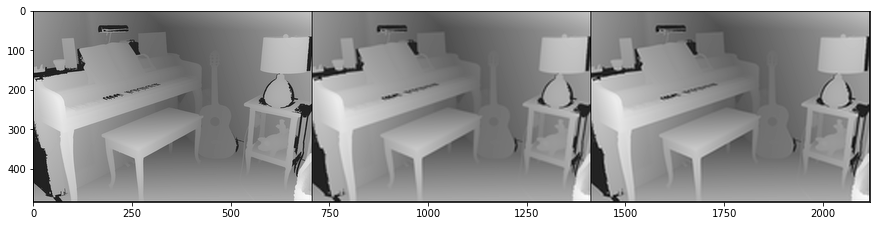

Bicubic SSIM:  0.9625572612316892
Bicubic PSNR:  30.048558079997147
Bicubic RMSE:  0.056582841392834454
Bicubic MAE:  0.008993212
Lanczos SSIM:  0.9627068251767645
Lanczos PSNR:  30.215127112964147
Lanczos RMSE:  0.05550809217236391
Lanczos MAE:  0.009206044


In [3]:
psnr_bicubic_list = []
ssim_bicubic_list = []
rmse_bicubic_list = []
mae_bicubic_list = []

psnr_res_list = []
ssim_res_list = []
rmse_res_list = []
mae_res_list = []

psnr_lanczos_list = []
ssim_lanczos_list = []
rmse_lanczos_list = []
mae_lanczos_list = []

for i in range(num_images):
    imgs = test_images[i]
    rgb_imgs = test_images_rgb[i]
#     print(imgs['HR_pil'].mode)
    imgs['bicubic_np'], imgs['lanczos_np'] = get_baselines_d(imgs['LR_pil'], imgs['HR_pil'])
    rgb_imgs['bicubic_np'], rgb_imgs['sharp_np'], rgb_imgs['lanczos_np'] = get_baselines(rgb_imgs['LR_pil'],
                                                                                         rgb_imgs['HR_pil'])
    if PLOT:
        plot_image_grid([np.expand_dims(imgs['HR_np'], 0), np.expand_dims(imgs['bicubic_np'], 0), np.expand_dims(imgs['lanczos_np'], 0)], 4,12);
        lanczos_psnr = compare_psnr(imgs['HR_np'], imgs['lanczos_np'])
        bicubic_psnr = compare_psnr(imgs['HR_np'], imgs['bicubic_np'])
        lanczos_ssim = compare_ssim(imgs['HR_np'], imgs['lanczos_np'])
        bicubic_ssim = compare_ssim(imgs['HR_np'], imgs['bicubic_np'])
        lanczos_rmse = compare_nrmse(imgs['HR_np'], imgs['lanczos_np'])
        bicubic_rmse = compare_nrmse(imgs['HR_np'], imgs['bicubic_np'])
        lanczos_mae = mean_absolute_error(imgs['HR_np'], imgs['lanczos_np'])
        bicubic_mae = mean_absolute_error(imgs['HR_np'], imgs['bicubic_np'])

        psnr_bicubic_list.append(bicubic_psnr)
        ssim_bicubic_list.append(bicubic_ssim)
        rmse_bicubic_list.append(bicubic_rmse)
        mae_bicubic_list.append(bicubic_mae)
        
        psnr_lanczos_list.append(lanczos_psnr)
        ssim_lanczos_list.append(lanczos_ssim)
        rmse_lanczos_list.append(lanczos_rmse)
        mae_lanczos_list.append(lanczos_mae)


# print(ssim_bicubic_list)
print("Bicubic SSIM: ", np.mean(ssim_bicubic_list))
print("Bicubic PSNR: ", np.mean(psnr_bicubic_list))
print("Bicubic RMSE: ", np.mean(rmse_bicubic_list))
print("Bicubic MAE: ", np.mean(mae_bicubic_list))

print("Lanczos SSIM: ", np.mean(ssim_lanczos_list))
print("Lanczos PSNR: ", np.mean(psnr_lanczos_list))
print("Lanczos RMSE: ", np.mean(rmse_lanczos_list))
print("Lanczos MAE: ", np.mean(mae_lanczos_list))

# Set up parameters and net

In [4]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

if factor == 4: 
    num_iter = 2500
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [5]:
idx = 0
imgs = test_images[idx]
rgb_imgs = test_images_rgb[idx]

In [7]:
print(rgb_imgs['HR_np'].shape)
print(rgb_imgs['orig_np'].shape)
print(rgb_imgs['LR_np'].shape)

print(imgs['HR_np'].shape)
print(imgs['orig_np'].shape)
print(imgs['LR_np'].shape)

print(np.min(rgb_imgs['HR_np']), np.max(rgb_imgs['HR_np']))
print(np.min(rgb_imgs['orig_np']), np.max(rgb_imgs['orig_np']))
print(np.min(rgb_imgs['LR_np']), np.max(rgb_imgs['LR_np']))

(3, 480, 704)
(3, 480, 704)
(3, 120, 176)
(480, 704)
(480, 704)
(120, 176)
0.0 1.0
0.0 1.0
0.0 1.0


In [8]:
# rgb_image = np.transpose(rgb_image, (2, 0, 1))
imgs['LR_np'] = np.clip(imgs['LR_np'], 0, 1)

net_input_1 = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

net = MaskApplyNetworkLast(num_input_channels=32,
                           num_output_channels=3,
                           num_channels_down=[128, 128, 128, 128, 128],
                           num_channels_up=[128, 128, 128, 128, 128],
                           act_fun='ReLU').type(dtype)

net = net.cuda()
init_weights = net.state_dict()
init_weights_copy = copy.deepcopy(init_weights)

mask_net = MaskGenNetwork(n_residual_blocks=12,
                          sr_factor=factor, #1 for Full Res
                          in_channels=1,
                          out_channels=128,
                          up_channels = 128,
                          half_scale=1).type(dtype)


mask_net = mask_net.cuda()

In [9]:
# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(np.expand_dims(imgs['LR_np'], 0)).type(dtype)
img_bicubic_var = np_to_torch(np.expand_dims(imgs['bicubic_np'], 0)).type(dtype)
img_LR_var_clone = img_LR_var.clone().detach()

rgb_LR_var = np_to_torch(rgb_imgs['LR_np']).type(dtype)
rgb_HR_var = np_to_torch(rgb_imgs['HR_np']).type(dtype)
rgb_LR_var_clone = rgb_LR_var.clone().detach()
rgb_HR_var_clone = rgb_HR_var.clone().detach()
# rgbd_var = torch.cat([rgb_image_var, img_bicubic_var], dim=1)
# rgbd_var_clone = rgbd_var.clone().detach()
# print(rgbd_var.shape)
    
downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [10]:
def closure():
    global i, net_input_1
    
    if reg_noise_std > 0:
        net_input = net_input_1 + (noise.normal_() * reg_noise_std)
#     else:
#     net_input = net_input_saved

    mask_1 = mask_net(img_LR_var_clone)
    mask_binary_1 = mask_1 > 0.5
    mask_binary_1 = mask_binary_1.float()
    
    mask_binary_1.requires_grad = True
    
    out_HR = net(net_input, mask_binary_1)
    out_LR = downsampler(out_HR)
    
    total_loss = mse(out_LR, rgb_LR_var)
    total_loss.backward()

    mask_1.backward(mask_binary_1.grad)

    # Log
#     psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    out_HR_np_sq = np.squeeze(torch_to_np(out_HR))
    psnr_HR = compare_psnr_y(rgb_imgs['HR_np'], out_HR_np_sq)
    ssim_HR = compare_ssim_y(rgb_imgs['HR_np'], out_HR_np_sq)
#     mse_HR = compare_nrmse(imgs['HR_np'], out_HR_np_sq)
    
#     ssim_HR = compare_ssim(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(torch_to_np(out_HR), (1, 2, 0)), multichannel=True)
    print ('Iteration %05d    PSNR_HR %.3f   SSIM_HR %.3f   Loss %.6f' % (i, psnr_HR, ssim_HR, total_loss.data), '\r', end='')
    
    if PLOT and (i % 100 == 0):
        psnr_history.append(psnr_HR)
        ssim_history.append(ssim_HR)
        iter_history.append(i)
        loss_history.append(total_loss.data)
#         mse_history.append(mse_HR)
#         out_HR_np = torch_to_np(out_HR)
#         plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['lanczos_np'], np.clip(out_HR_np, 0, 1)], factor=8, nrow=2)

    i += 1
    
    return total_loss

In [11]:
psnr_history = []
mse_history = []
ssim_history = []
iter_history = []
loss_history = []

net_input_saved = net_input_1.detach().clone()
noise = net_input_1.detach().clone()

i = 0

dip_params = get_params(OPT_OVER, net, net_input_1)
mask_params = get_params(OPT_OVER, mask_net, net_input_1)

# for a in net.named_parameters():
#     print(a[0])
# print('------------------')
# for a in mask_net.named_parameters():
#     print(a[0])
# mask.requires_grad = True

In [12]:
optimizer = torch.optim.Adam([{'params': dip_params, 'lr': 0.001},
                             {'params': mask_params, 'lr': 0.001}])
# parameters = dip_params + mask_params


for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [27]:
net2 = MaskApplyNetworkLast(num_input_channels=3,
                           num_output_channels=1,
                           num_channels_down=[128, 128, 128, 128, 128],
                           num_channels_up=[128, 128, 128, 128, 128],
                           act_fun='ReLU').type(dtype)

net2 = net2.cuda()

downsampler_single = Downsampler(n_planes=1, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
# net2.load_state_dict(init_weights_copy)

In [28]:
mask_1 = mask_net(img_LR_var_clone)
mask_binary_1 = mask_1 > 0.5
mask_binary_1 = mask_binary_1.float()

/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [29]:
def closure2():
    global i, mask_binary_1
    
#     if reg_noise_std > 0:
#         net_input = net_input_1 + (noise.normal_() * reg_noise_std)
#     else:
#     net_input = rgb_HR_var_clone

#     mask_1 = mask_net(img_LR_var_clone)
#     mask_binary_1 = mask_1 > 0.5
#     mask_binary_1 = mask_binary_1.float()
    
#     mask_binary_1.requires_grad = True
    
    out_HR = net2(rgb_HR_var_clone, mask_binary_1)
    out_LR = downsampler_single(out_HR)
    
    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()

#     mask_1.backward(mask_binary_1.grad)

    # Log
#     psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    out_HR_np_sq = np.squeeze(torch_to_np(out_HR))
    psnr_HR = compare_psnr(imgs['HR_np'], out_HR_np_sq)
    ssim_HR = compare_ssim(imgs['HR_np'], out_HR_np_sq)
    mse_HR = compare_nrmse(imgs['HR_np'], out_HR_np_sq)
    
#     ssim_HR = compare_ssim(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(torch_to_np(out_HR), (1, 2, 0)), multichannel=True)
    print ('Iteration %05d    PSNR_HR %.3f   SSIM_HR %.3f   Loss %.6f' % (i, psnr_HR, ssim_HR, total_loss.data), '\r', end='')
    
    if PLOT and (i % 100 == 0):
        psnr_history.append(psnr_HR)
        ssim_history.append(ssim_HR)
        iter_history.append(i)
        loss_history.append(total_loss.data)
        mse_history.append(mse_HR)
#         out_HR_np = torch_to_np(out_HR)
#         plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['lanczos_np'], np.clip(out_HR_np, 0, 1)], factor=8, nrow=2)

    i += 1
    
    return total_loss

In [30]:
psnr_history = []
mse_history = []
ssim_history = []
iter_history = []
loss_history = []

i = 0

dip_params = get_params(OPT_OVER, net2, net_input_1)
optimizer = torch.optim.Adam([{'params': dip_params, 'lr': 0.001}])
# parameters = dip_params + mask_params


for j in range(num_iter):
    optimizer.zero_grad()
    closure2()
    optimizer.step()

/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
mask_binary = mask_binary_1.cpu().numpy()

In [ ]:
# Visualize Masks
plt.figure(figsize=(16, 16))
for i in range(128):
    plt.subplot(16, 8, i+1)
    plt.imshow(mask_binary[0, i, :, :], cmap='gray')
    plt.axis('off')

In [ ]:
out_HR = net(net_input_1, mask_binary_1.float())
psnr_HR = compare_psnr_y(imgs['HR_np'], torch_to_np(out_HR))
ssim_HR = compare_ssim_y(imgs['HR_np'], torch_to_np(out_HR))
mse_HR = compare_mse(imgs['HR_np'], torch_to_np(out_HR))
    
# ssim_HR = compare_ssim(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(torch_to_np(out_HR), (1, 2, 0)), multichannel=True)

print("PSNR: ", psnr_HR)
print("SSIM: ", ssim_HR)
print("RMSE: ", mse_HR**0.5)

out_HR_np = np.clip(torch_to_np(out_HR), 0, 1)
print(out_HR_np.shape)
plot_image_grid([out_HR_np], factor=8, nrow=1)

# Save image
file_path = 'data/sr/set5/res/butterfly_2.png'
import skimage.io as sio
sio.imsave(file_path, np.transpose(out_HR_np, (1, 2, 0)))

In [ ]:
plt.plot(iter_history, psnr_history)

In [ ]:
plt.plot(iter_history, ssim_history)

In [ ]:
plt.plot(iter_history, mse_history)